# Task 2

### Loading the Dataset

In [0]:
# Importing needed libaries
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col, isnan, when, count, lit, sum as _sum, log1p, skewness
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
dbutils.fs.ls("/FileStore/tables/")

[FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1712156823000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1715218433000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1712694645000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1715218430000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.zip', name='clinicaltrial_2021.zip', size=11508457, modificationTime=1712694645000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1715218424000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial

In [0]:
dbutils.fs.cp("dbfs:/FileStore/tables/steam_200k.csv", "file:/tmp/steam_200k.csv")

True

In [0]:
# File location
file_location = "/FileStore/tables/steam_200k.csv"  # Adjusted to DBFS path
file_type = "csv"

# CSV options
first_row_is_header = "false"
delimiter = ","

# Define schema explicitly
steam_schema = StructType([
    StructField("UserID", StringType(), True),
    StructField("GameName", StringType(), True),
    StructField("Behavior", StringType(), True),
    StructField("Value", FloatType(), True)
])

# Load the CSV file into a DataFrame using the specified schema
steam_df = spark.read.format(file_type) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(steam_schema) \
  .load(file_location)

# Show the DataFrame to verify successful load
steam_df.show(10)

+---------+--------------------+--------+-----+
|   UserID|            GameName|Behavior|Value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
+---------+--------------------+--------+-----+
only showing top 10 rows



## Cleaning Dataset

In [0]:
# Check for missing or null values in each column
missing_values_df = steam_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in steam_df.columns])

# Display missing values count for each column, including those with 0 missing values
missing_values_df.show()

+------+--------+--------+-----+
|UserID|GameName|Behavior|Value|
+------+--------+--------+-----+
|     0|       0|       0|    0|
+------+--------+--------+-----+



In [0]:
# Checking for duplicate values
duplicate_count = steam_df.groupBy(steam_df.columns).count().where('count > 1').count()

# Display the count of duplicate rows
print("Number of duplicate rows:", duplicate_count)

# Find and display duplicate rows
duplicate_rows = steam_df.groupBy(steam_df.columns).count().where('count > 1')
duplicate_rows.show()

Number of duplicate rows: 707
+---------+--------------------+--------+-----+-----+
|   UserID|            GameName|Behavior|Value|count|
+---------+--------------------+--------+-----+-----+
| 47672756|Grand Theft Auto III|purchase|  1.0|    2|
|157095466|Sid Meier's Civil...|purchase|  1.0|    2|
|127335438|Grand Theft Auto III|purchase|  1.0|    2|
|150882304|Sid Meier's Civil...|purchase|  1.0|    2|
|100351493|Sid Meier's Civil...|purchase|  1.0|    2|
| 65398650|Sid Meier's Civil...|purchase|  1.0|    2|
| 71390526|Sid Meier's Civil...|purchase|  1.0|    2|
|101731521|Grand Theft Auto III|purchase|  1.0|    2|
| 11813637|Sid Meier's Civil...|purchase|  1.0|    2|
| 11373749|Sid Meier's Civil...|purchase|  1.0|    2|
|178168238|Sid Meier's Civil...|purchase|  1.0|    2|
| 80779496|Sid Meier's Civil...|purchase|  1.0|    2|
| 33865373|Sid Meier's Civil...|purchase|  1.0|    2|
|105877396|Sid Meier's Civil...|purchase|  1.0|    2|
|161659407|Sid Meier's Civil...|purchase|  1.0|    2

## EDA

In [0]:
# Count how many unique games are in the dataset and how many unique user are there
unique_games = steam_df.select("GameName").distinct().count()
unique_users = steam_df.select("UserID").distinct().count()
print(f"Unique games: {unique_games}")
print(f"Unique users: {unique_users}")


Unique games: 5155
Unique users: 12393


In [0]:
# First, calculate the total number of records
total_records = steam_df.count()

# Group by 'Behavior', count, and calculate the percentage
purchase_play_percentage = steam_df.groupBy("Behavior") \
    .count() \
    .withColumn("Percentage", F.round((col("count") / lit(total_records)) * 100, 2))

purchase_play_percentage.show()

+--------+------+----------+
|Behavior| count|Percentage|
+--------+------+----------+
|purchase|129511|     64.76|
|    play| 70489|     35.24|
+--------+------+----------+



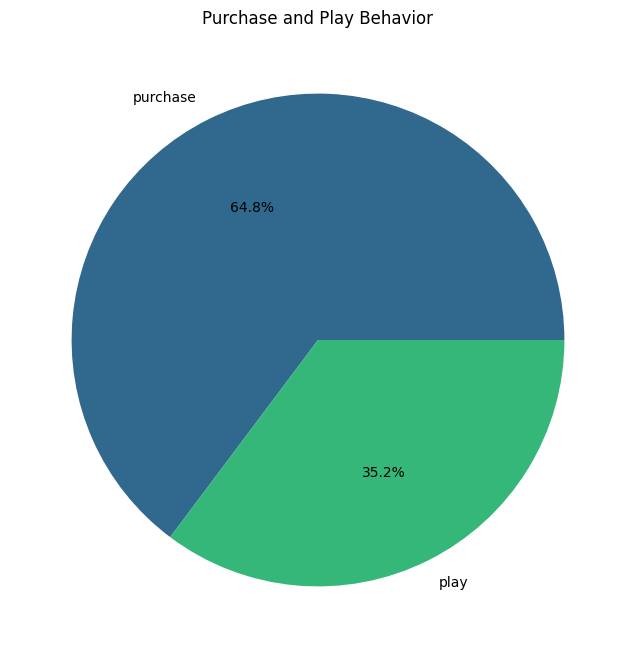

In [0]:
# Convert to Pandas DataFrame for visualization
purchase_play_percentage_pd = purchase_play_percentage.toPandas()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(purchase_play_percentage_pd['Percentage'], labels=purchase_play_percentage_pd['Behavior'], autopct='%1.1f%%', colors=sns.color_palette("viridis", len(purchase_play_percentage_pd)))
plt.title('Purchase and Play Behavior')
plt.show()

In [0]:
# Top Games by Playtime

steam_df.filter(steam_df.Behavior == "play") \
  .groupBy("GameName") \
  .agg(_sum("Value").alias("TotalHours")) \
  .orderBy("TotalHours", ascending=False) \
  .limit(10)\
  .show()


+--------------------+------------------+
|            GameName|        TotalHours|
+--------------------+------------------+
|              Dota 2| 981684.6000046805|
|Counter-Strike Gl...|322771.60000587255|
|     Team Fortress 2|173673.30000534654|
|      Counter-Strike| 134261.1000032574|
|Sid Meier's Civil...| 99821.30000032485|
|Counter-Strike So...|  96075.4999980852|
|The Elder Scrolls...| 70889.30000342429|
|         Garry's Mod|49725.300001084805|
|Call of Duty Mode...|  42009.8999973014|
|       Left 4 Dead 2| 33596.70000024885|
+--------------------+------------------+



In [0]:
# Top Games by Purchase

steam_df.filter(steam_df.Behavior == "purchase") \
  .groupBy("GameName") \
  .count() \
  .orderBy("count", ascending=False) \
  .limit(10)\
  .show()

+--------------------+-----+
|            GameName|count|
+--------------------+-----+
|              Dota 2| 4841|
|     Team Fortress 2| 2323|
|            Unturned| 1563|
|Counter-Strike Gl...| 1412|
|Half-Life 2 Lost ...|  981|
|Counter-Strike So...|  978|
|       Left 4 Dead 2|  951|
|      Counter-Strike|  856|
|            Warframe|  847|
|Half-Life 2 Death...|  823|
+--------------------+-----+



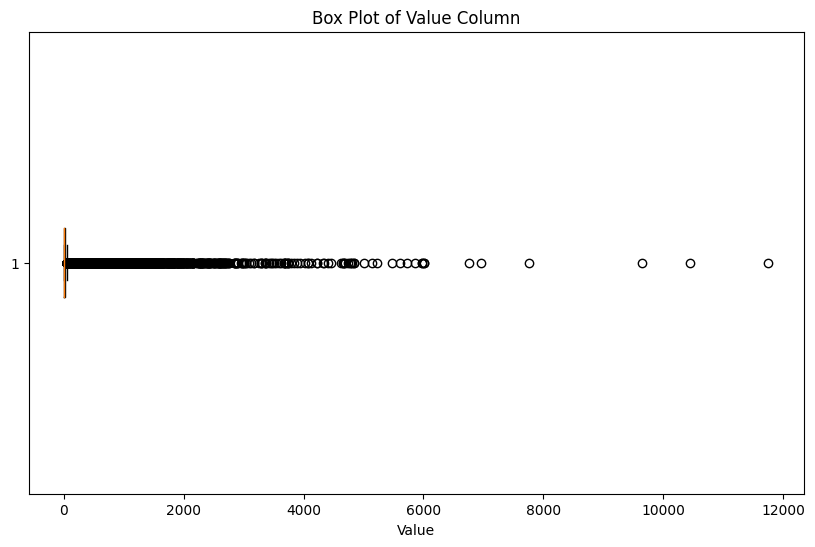

In [0]:
# Filterig only play behaviour
steam_df_pb = steam_df.filter(steam_df.Behavior == "play")

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = steam_df_pb.select("Value").toPandas()

# Creating a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(pandas_df["Value"], vert=False)
plt.title('Box Plot of Value Column')
plt.xlabel('Value')
plt.show()

In [0]:
# Display statistical summary
steam_df_pb.describe("Value").show()

+-------+------------------+
|summary|             Value|
+-------+------------------+
|  count|             70489|
|   mean|48.878063245103164|
| stddev|229.33523599657818|
|    min|               0.1|
|    max|           11754.0|
+-------+------------------+



In [0]:
# Calculate skewness for the 'Value' column
skewness = steam_df_pb.select(skewness("Value")).collect()[0][0]

# Display the initial skewness
print("Initial Skewness of 'Value' column:", skewness)


Initial Skewness of 'Value' column: 15.089001866031996


/root/.ipykernel/1189/command-3438182364934871-1845464887:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pandas_df["Value"], shade=True, color="blue")


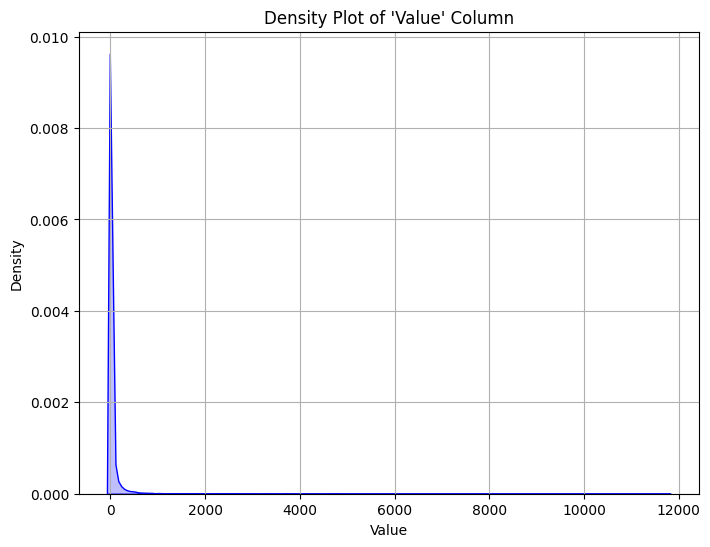

In [0]:
# Create a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(pandas_df["Value"], shade=True, color="blue")
plt.title("Density Plot of 'Value' Column")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


### Machine learning

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import mlflow
import mlflow.spark
from pyspark.sql.functions import col, lit, expr
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import explode

# Start MLflow autologging
mlflow.pyspark.ml.autolog()

In [0]:
# Indexing GameName to a numeric ID
game_indexer = StringIndexer(inputCol="GameName", outputCol="gameID")
steam_df_new = game_indexer.fit(steam_df).transform(steam_df)

# Cast gameIndex to integer
steam_df_new = steam_df_new.withColumn("gameID", col("gameID").cast("integer"))

2024/05/09 02:00:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b7fe24003e594495aaf1679f35ca39fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


In [0]:
# Cast UserID to integer
steam_df_new = steam_df_new.withColumn("UserID", col("UserID").cast("integer"))

In [0]:
# DataFrame Schema
steam_df_new.printSchema()

root
 |-- UserID: integer (nullable = true)
 |-- GameName: string (nullable = true)
 |-- Behavior: string (nullable = true)
 |-- Value: float (nullable = true)
 |-- gameID: integer (nullable = true)



In [0]:
# Filterig only play behaviour
steam_df_play = steam_df_new.filter(steam_df_new.Behavior == "play")

In [0]:
# Flitering bt IQR
# Using a larger IQR multiplier
quantiles = steam_df_play.approxQuantile("Value", [0.25, 0.75], 0.05)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1
multiplier = 3.0  # less aggressive
lower_bound = Q1 - multiplier * IQR
upper_bound = Q3 + multiplier * IQR

# Applying less aggressive filtering
steam_df_filtered = steam_df_play.filter((col("Value") >= lit(lower_bound)) & (col("Value") <= lit(upper_bound)))

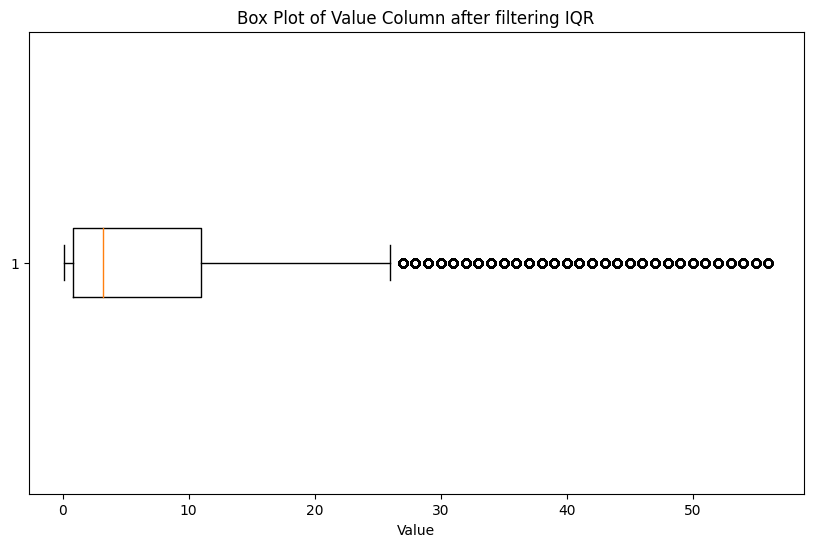

In [0]:
pandas_df = steam_df_filtered.select("Value").toPandas()

# Creating a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(pandas_df["Value"], vert=False)
plt.title('Box Plot of Value Column after filtering IQR')
plt.xlabel('Value')
plt.show()

In [0]:
# Display statistical summary
steam_df_filtered.describe("Value").show()


+-------+------------------+
|summary|             Value|
+-------+------------------+
|  count|             61821|
|   mean|     8.43044920147|
| stddev|11.719015247449288|
|    min|               0.1|
|    max|              56.0|
+-------+------------------+



In [0]:
# Set up ALS model
als = ALS(maxIter=10, regParam=0.2, userCol="UserID", itemCol="gameID", ratingCol="Value", coldStartStrategy="drop", nonnegative=True)

In [0]:
# Split data into train and test sets
(train, test) = steam_df_filtered.randomSplit([0.8, 0.2], seed=100)

In [0]:
# Fit model on training data
steam_model = als.fit(train)

# Make predictions on the test data
predictions = steam_model.transform(test)

2024/05/09 02:00:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e3cd9e573b24ee48dc144708293065f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:00:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# Evaluating the Model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")
rmse_IQR = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse_IQR}")

Root-mean-square error = 13.091470180233918


### Recommendation

#### (I) Game recomedation for each user

In [0]:
# Top game recommendations with ratings
userRecs = steam_model.recommendForAllUsers(10)
userRecs.display()

UserID recommendations 76767 List(List(4077, 90.319016), List(508, 56.638153), List(1263, 54.764668), List(2751, 52.961292), List(1735, 48.16588), List(215, 45.762085), List(2243, 45.46261), List(1822, 43.80745), List(616, 43.365147), List(1221, 42.73179)) 144736 List(List(4077, 0.24629778), List(1263, 0.2444785), List(928, 0.2219416), List(260, 0.19666573), List(544, 0.19104673), List(1127, 0.1861075), List(258, 0.1850346), List(2071, 0.18162505), List(187, 0.17177863), List(565, 0.1709512)) 229911 List(List(1127, 124.02436), List(544, 117.62791), List(2354, 104.795616), List(1198, 104.771706), List(1695, 101.242744), List(3258, 101.031654), List(2291, 95.91458), List(187, 95.88231), List(1385, 93.23106), List(456, 91.45508)) 948368 List(List(544, 15.031528), List(1127, 14.443902), List(2354, 13.325713), List(1198, 13.183148), List(1695, 12.734228), List(2291, 12.162077), List(187, 11.806712), List(3258, 11.389648), List(456, 11.124829), List(292, 10.439687)) 975449 List(List(1978, 43.62028), List(540, 36.582012), List(240, 36.033024), List(1385, 31.892256), List(322, 31.350912), List(716, 30.94041), List(116, 29.96967), List(2422, 29.967133), List(261, 29.059502), List(2599, 28.389172)) 2531540 List(List(1127, 36.228985), List(1385, 36.098515), List(3258, 34.237923), List(726, 33.134476), List(1978, 32.14768), List(618, 30.746462), List(1442, 30.010838), List(540, 29.534744), List(211, 25.463322), List(104, 25.282053)) 2753525 List(List(2354, 47.49387), List(2749, 44.349304), List(2751, 43.068718), List(2215, 40.5354), List(1705, 36.462738), List(2692, 34.523712), List(4077, 34.39539), List(4453, 34.038975), List(1069, 32.4616), List(3175, 32.45783)) 3450426 List(List(1385, 1.3120166), List(462, 1.2704748), List(1978, 1.251704), List(4353, 1.1826222), List(754, 1.1608386), List(540, 1.1182466), List(464, 1.0980587), List(726, 1.0356507), List(3258, 1.0356282), List(981, 1.0032294)) 7923954 List(List(4077, 0.73889333), List(1263, 0.7334355), List(928, 0.66582483), List(260, 0.58999723), List(544, 0.5731402), List(1127, 0.55832255), List(258, 0.55510384), List(2071, 0.54487514), List(187, 0.5153359), List(565, 0.5128536)) 8259307 List(List(1069, 29.686987), List(1493, 24.880516), List(597, 24.15591), List(2749, 23.954132), List(2354, 20.954245), List(265, 20.750282), List(688, 20.200535), List(1243, 19.251366), List(543, 19.129162), List(250, 19.120321)) 8567888 List(List(4077, 4.2227306), List(508, 2.578351), List(1263, 2.5573878), List(2898, 2.4228308), List(1896, 2.3993104), List(215, 2.2425604), List(1221, 2.102804), List(555, 2.0356932), List(1036, 1.9572299), List(4353, 1.949723)) 8585433 List(List(2749, 71.546295), List(1907, 51.02024), List(2599, 46.413074), List(372, 44.254486), List(1705, 43.341724), List(1974, 43.102375), List(717, 42.70984), List(57, 42.60054), List(1043, 42.219143), List(867, 41.566658)) 8784496 List(List(1127, 37.98191), List(2354, 31.795816), List(2751, 30.003), List(2399, 27.839365), List(1349, 27.666424), List(567, 26.890163), List(1978, 26.548897), List(1822, 26.050653), List(1972, 25.466331), List(1735, 24.0888)) 8795607 List(List(1896, 137.70374), List(1735, 131.35468), List(571, 123.24613), List(1655, 118.306274), List(719, 115.83788), List(2751, 108.14738), List(1127, 107.334564), List(1822, 102.87102), List(469, 102.32497), List(805, 100.164276)) 10595342 List(List(1545, 158.00458), List(1751, 133.5984), List(36, 127.82385), List(2692, 126.585884), List(800, 124.92557), List(1382, 121.00035), List(2751, 114.297165), List(736, 104.43679), List(4453, 103.22516), List(366, 98.18837)) 10599862 List(List(2354, 65.8924), List(1806, 60.580784), List(2751, 60.471855), List(1127, 59.54469), List(544, 59.51025), List(3175, 58.297962), List(3258, 55.357105), List(2732, 54.107708), List(1198, 53.4158), List(2215, 51.675014)) 11807754 List(List(1907, 41.192078), List(208, 36.877953), List(4325, 35.973534), List(331, 32.68313), List(469, 29.527056), List(717, 28.763025), List(567, 28.700262), List(106

In [0]:

# Explode the recommendations array to separate rows
userRecsExploded = userRecs.select(
    userRecs.UserID,
    explode(userRecs.recommendations)
).select(
    "UserID",
    col("col.gameID").alias("RecommendedGame"),
    col("col.rating").alias("Pred_game_hours")
)
userRecsExploded.show()

+------+---------------+---------------+
|UserID|RecommendedGame|Pred_game_hours|
+------+---------------+---------------+
| 76767|           4077|      90.319016|
| 76767|            508|      56.638153|
| 76767|           1263|      54.764668|
| 76767|           2751|      52.961292|
| 76767|           1735|       48.16588|
| 76767|            215|      45.762085|
| 76767|           2243|       45.46261|
| 76767|           1822|       43.80745|
| 76767|            616|      43.365147|
| 76767|           1221|       42.73179|
|144736|           4077|     0.24629778|
|144736|           1263|      0.2444785|
|144736|            928|      0.2219416|
|144736|            260|     0.19666573|
|144736|            544|     0.19104673|
|144736|           1127|      0.1861075|
|144736|            258|      0.1850346|
|144736|           2071|     0.18162505|
|144736|            187|     0.17177863|
|144736|            565|      0.1709512|
+------+---------------+---------------+
only showing top

In [0]:
gameIndexNameMap = steam_df_new.select("GameName", "gameID").distinct()

In [0]:

# since userRecsExploded is my exploded recommendations DataFrame
recommendationsWithName = userRecsExploded.join(gameIndexNameMap, userRecsExploded.RecommendedGame == gameIndexNameMap.gameID)

# Selecting and renaming columns as needed
finalRecommendations = recommendationsWithName.select(
    "UserID",
    col("GameName").alias("RecommendedGameName"),
    "Pred_game_hours"
)

In [0]:
display(finalRecommendations.limit(20))

UserID RecommendedGameName Pred_game_hours 76767 Hotel Giant 2 90.319016 76767 Call of Duty Black Ops III 56.638153 76767 Life is Feudal Your Own 54.764668 76767 Pro Evolution Soccer 2016 52.961292 76767 Tom Clancy's Rainbow Six Siege 48.16588 76767 Crusader Kings II 45.762085 76767 Epic Battle Fantasy 4 45.46261 76767 NBA 2K13 43.80745 76767 Vampire The Masquerade - Bloodlines 43.365147 76767 Grim Dawn 42.73179 144736 Hotel Giant 2 0.24629778 144736 Life is Feudal Your Own 0.2444785 144736 Combat Arms 0.2219416 144736 Football Manager 2012 0.19666573 144736 S.T.A.L.K.E.R. Call of Pripyat 0.19104673 144736 Gothic 3 0.1861075 144736 Tropico 4 0.1850346 144736 Lifeless Planet 0.18162505 144736 Star Wars Knights of the Old Republic 0.17177863 144736 Total War ATTILA 0.1709512

In [0]:
# Assuming we're interested in this specific UserID
specific_user_id = 60296891

# Filter the finalRecommendations DataFrame for the specific UserID
specific_user_recs = finalRecommendations.filter(finalRecommendations.UserID == specific_user_id)

# Display the recommendations for the specific UserID
display(specific_user_recs)

UserID RecommendedGameName Pred_game_hours 60296891 Hotel Giant 2 69.70566 60296891 Tom Clancy's Rainbow Six Siege 63.864513 60296891 Pro Evolution Soccer 2016 60.583218 60296891 NBA 2K13 57.931355 60296891 Call of Duty Black Ops III 54.243988 60296891 LEGO Batman 3 Beyond Gotham 53.78798 60296891 Gothic 3 52.135876 60296891 FINAL FANTASY XIV A Realm Reborn 51.611244 60296891 Borderlands 2 RU 50.681942 60296891 Pro Evolution Soccer 2015 47.996517

#### (II) Top user recommendations for each game:

In [0]:
gameRecs = steam_model.recommendForAllItems(10)
gameRecs.show()

+------+--------------------+
|gameID|     recommendations|
+------+--------------------+
|    12|[{208821410, 85.7...|
|    26|[{169851136, 78.2...|
|    27|[{70751383, 141.9...|
|    28|[{237879937, 48.5...|
|    31|[{27117407, 55.27...|
|    34|[{106816274, 12.6...|
|    44|[{237879937, 51.8...|
|    53|[{208821410, 92.4...|
|    65|[{27117407, 143.0...|
|    76|[{204908772, 59.3...|
|    78|[{281824528, 69.9...|
|    81|[{65244880, 152.3...|
|    85|[{237879937, 28.6...|
|    91|[{27117407, 91.00...|
|   101|[{237879937, 64.9...|
|   103|[{106816274, 57.2...|
|   108|[{243808511, 111....|
|   115|[{106816274, 25.2...|
|   126|[{237879937, 98.5...|
|   133|[{223660563, 52.0...|
+------+--------------------+
only showing top 20 rows



In [0]:
# Explode the recommendations array to separate rows
gameRecsExploded = gameRecs.select(
    gameRecs.gameID, 
    explode(gameRecs.recommendations)
).select(
    col("gameID").alias("gameID"),  
    col("col.UserId").alias("RecommendedUser"),
    col("col.rating").alias("Rating")
)
gameRecsExploded.show()

+------+---------------+---------+
|gameID|RecommendedUser|   Rating|
+------+---------------+---------+
|    12|      208821410| 85.77958|
|    12|      100359523|63.347965|
|    12|       47296055| 57.41908|
|    12|      223660563|56.158978|
|    12|       79411077| 55.81482|
|    12|       12529679| 53.70421|
|    12|       99083518|53.470192|
|    12|      136493411|52.362015|
|    12|      222600281| 52.13083|
|    12|       52723676|51.735043|
|    26|      169851136|78.280334|
|    26|      248255491|  77.3674|
|    26|       98463542|77.200195|
|    26|       60557056| 70.91685|
|    26|       67349307| 68.62671|
|    26|      284729488| 68.24184|
|    26|      180438232| 68.11022|
|    26|      116494569|67.478096|
|    26|       98278869| 65.23752|
|    26|      122551425|64.595825|
+------+---------------+---------+
only showing top 20 rows



In [0]:
display(gameRecsExploded.limit(10))

gameID RecommendedUser Rating 12 208821410 85.77958 12 100359523 63.347965 12 47296055 57.41908 12 223660563 56.158978 12 79411077 55.81482 12 12529679 53.70421 12 99083518 53.470192 12 136493411 52.362015 12 222600281 52.13083 12 52723676 51.735043

## Hyperparameter

In [0]:
# Define your parameter grid
params = {
    'maxIter': [5, 10, 15, 20],  # Maximum number of iterations
    'regParam': [0.05, 0.5, 0.8, 1]  # Regularization parameter
}

In [0]:
# Initialize variables to track the best parameters and RMSE
best_rmse = float('inf')
best_params = None

# Evaluator for measuring RMSE
evaluator_hyper = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")

# Nested loops to iterate over all combinations of parameters in the grid
for maxIter in params['maxIter']:
    for regParam in params['regParam']:
        
        # Initialize the ALS model with current parameters
        als_hyper = ALS(maxIter=maxIter, regParam=regParam, userCol='UserID', itemCol='gameID', ratingCol='Value', coldStartStrategy="drop", nonnegative=True, seed=100)
        
        # Fit model on training data
        steam_model_hyper = als_hyper.fit(train)

        # Make predictions on the test data
        predictions_hyper = steam_model_hyper.transform(test)

        # Evaluate the model
        rmse_hyper = evaluator_hyper.evaluate(predictions_hyper)
        
        # Print the current parameter combination and its RMSE
        print(f"Parameters: maxIter={maxIter}, regParam={regParam} | RMSE: {rmse_hyper}")

        # Update the best parameters and RMSE if the current model has lower RMSE
        if rmse_hyper < best_rmse:
            best_rmse = rmse_hyper
            best_params = {'maxIter': maxIter, 'regParam': regParam}

2024/05/09 02:05:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0abae671e9e5488aba3c535824b9c747', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:05:38 WARNING mlflow.pyspark.ml: Model ALS_2086b2cd5309 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=5, regParam=0.05 | RMSE: 15.26835783934204


2024/05/09 02:05:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ea18e0985c484175828d9512e23242ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:06:10 WARNING mlflow.pyspark.ml: Model ALS_31163e0e66c8 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=5, regParam=0.5 | RMSE: 12.077742938524047


2024/05/09 02:06:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ae931c0a4a4c42038b7896e67cbce035', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:06:41 WARNING mlflow.pyspark.ml: Model ALS_3850aa197f9f will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=5, regParam=0.8 | RMSE: 11.80103568904081


2024/05/09 02:06:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '275fd243b14b442fbed7c4feb91f6fae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:07:14 WARNING mlflow.pyspark.ml: Model ALS_bc6911aa20ec will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=5, regParam=1 | RMSE: 11.65049974578445


2024/05/09 02:07:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '418224401a344c2d971d1c2bf63402f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:07:59 WARNING mlflow.pyspark.ml: Model ALS_c96d0042efc2 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=10, regParam=0.05 | RMSE: 15.383980653565454


2024/05/09 02:08:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04c41b30b3e04717bcb9f7c38546e6f8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:08:49 WARNING mlflow.pyspark.ml: Model ALS_e8a2f063a4aa will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=10, regParam=0.5 | RMSE: 12.258148571015614


2024/05/09 02:09:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0236201db7d94047aa72d9f96d82adab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:09:36 WARNING mlflow.pyspark.ml: Model ALS_826802595120 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=10, regParam=0.8 | RMSE: 11.873069170837418


2024/05/09 02:09:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '857d07e960c44b4288b363c7881e30c6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:10:24 WARNING mlflow.pyspark.ml: Model ALS_fcd8cb9293b7 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=10, regParam=1 | RMSE: 11.714810064704414


2024/05/09 02:10:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c89fc254546b44ed970f32893d056249', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:11:35 WARNING mlflow.pyspark.ml: Model ALS_a790153aa3dc will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=15, regParam=0.05 | RMSE: 15.567980494993039


2024/05/09 02:11:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e90109ff34c04aa59cd502686e9e3366', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:12:53 WARNING mlflow.pyspark.ml: Model ALS_48c41f0aa8fe will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=15, regParam=0.5 | RMSE: 12.344267920474383


2024/05/09 02:13:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0e832eb44bba42e0b9d3303398bab3c8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:14:10 WARNING mlflow.pyspark.ml: Model ALS_9140b1aaf814 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=15, regParam=0.8 | RMSE: 11.898001029802867


2024/05/09 02:14:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fd02416473994c2596c886c4f223cced', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:15:29 WARNING mlflow.pyspark.ml: Model ALS_a0d13c152c16 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=15, regParam=1 | RMSE: 11.725520712019842


2024/05/09 02:15:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '92dfba2a22a54993bcfe4fd9558a9649', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:17:28 WARNING mlflow.pyspark.ml: Model ALS_634244ab8ab7 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=20, regParam=0.05 | RMSE: 15.687374977980175


2024/05/09 02:18:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ea5aefb5917f46e989b275cd69f03f28', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:19:35 WARNING mlflow.pyspark.ml: Model ALS_af9fb2d82387 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=20, regParam=0.5 | RMSE: 12.372852621817469


2024/05/09 02:20:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29e4af5016eb46279449f0be75caf1c5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:21:41 WARNING mlflow.pyspark.ml: Model ALS_9ad3e943f9f7 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=20, regParam=0.8 | RMSE: 11.9203067180814


2024/05/09 02:22:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2a38d0f863a241539dc6cdcea62023d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:23:47 WARNING mlflow.pyspark.ml: Model ALS_ca5b1d84d6a8 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Parameters: maxIter=20, regParam=1 | RMSE: 11.720160446413495


In [0]:
# Print the best RMSE and parameters found
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

Best RMSE: 11.65049974578445
Best Parameters: {'maxIter': 5, 'regParam': 1}


## Hyper Recommendation
##### I.e recommendation after hyperparameter tuning

In [0]:
# Initialize the ALS model with the best parameters
best_als_model = ALS(maxIter=best_params['maxIter'], 
                     regParam=best_params['regParam'], 
                     userCol='UserID', 
                     itemCol='gameID', 
                     ratingCol='Value', 
                     coldStartStrategy="drop", 
                     nonnegative=True, 
                     seed=100)

# Fit the model on the entire dataset
best_model_trained = best_als_model.fit(steam_df_filtered)


2024/05/09 02:24:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5e70a7145ac24e23b09355e596f40002', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/09 02:24:33 WARNING mlflow.pyspark.ml: Model ALS_b8490ce0c3f9 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


In [0]:
# Make recommendations for all users
hyper_user_recommendations = best_model_trained.recommendForAllUsers(10)

# Explode the recommendations array to separate rows
hyper_user_recommendations_exploded = hyper_user_recommendations.select(
    hyper_user_recommendations.UserID,
    explode(hyper_user_recommendations.recommendations)
).select(
    "UserID",
    col("col.gameID").alias("RecommendedGame"),
    col("col.rating").alias("Pred_game_hours")
)

# Join with the game names
gameIndexNameMap = steam_df_new.select("GameName", "gameID").distinct()
hyper_user_recommendations_with_names = hyper_user_recommendations_exploded.join(
    gameIndexNameMap,
    hyper_user_recommendations_exploded.RecommendedGame == gameIndexNameMap.gameID
).select(
    "UserID",
    col("GameName").alias("RecommendedGameName"),
    "Pred_game_hours"
)

In [0]:
# Display the recommendations
hyper_user_recommendations_with_names.show()

+------+--------------------+---------------+
|UserID| RecommendedGameName|Pred_game_hours|
+------+--------------------+---------------+
| 76767|You Must Build A ...|      41.630955|
| 76767|    Sunrider Academy|      37.006054|
| 76767|Pro Evolution Soc...|      35.834217|
| 76767|              Impire|       34.32009|
| 76767|              Runers|      33.692017|
| 76767|Pro Cycling Manag...|       32.48364|
| 76767|            NBA 2K14|      32.416862|
| 76767|Tom Clancy's Rain...|       32.11182|
| 76767|    Fight The Dragon|      31.886435|
| 76767|        RPG Maker MV|      31.546368|
|144736|           Majesty 2|     0.18409939|
|144736|         StarDrive 2|      0.1596541|
|144736|Life is Feudal Yo...|     0.15576366|
|144736|       Infinifactory|     0.14822653|
|144736|          Robin Hood|     0.14629793|
|144736|Tom Clancy's Ghos...|     0.14330019|
|144736|       Sorcerer King|     0.14032878|
|144736|Baldur's Gate II ...|     0.13838826|
|144736|         Combat Arms|     

In [0]:
# Assuming we're interested in this specific UserID
hyper_specific_user_id = 60296891

# Filter the hyper_user_recommendations DataFrame for the specific UserID
hyper_specific_user_recs = hyper_user_recommendations_with_names.filter(hyper_user_recommendations_with_names.UserID == hyper_specific_user_id)

# Display the recommendations for the specific UserID
display(hyper_specific_user_recs)

UserID RecommendedGameName Pred_game_hours 60296891 Majesty 2 39.39058 60296891 You Must Build A Boat 33.086094 60296891 Rayman Legends 28.656712 60296891 Pro Cycling Manager 2013 28.278984 60296891 Tom Clancy's Ghost Recon Future Soldier 28.226574 60296891 Soul Gambler 27.808414 60296891 Baldur's Gate II Enhanced Edition 27.041494 60296891 Majesty 2 Collection 27.016685 60296891 East India Company 25.769758 60296891 Sunrider Academy 25.612217

In [0]:
# Make recommendations for all items (games) using the best model
hyper_game_recommendations = best_model_trained.recommendForAllItems(10)
hyper_game_recommendations.show()

+------+--------------------+
|gameID|     recommendations|
+------+--------------------+
|    12|[{237879937, 53.3...|
|    26|[{235770634, 40.4...|
|    27|[{179077731, 84.4...|
|    28|[{37026839, 33.72...|
|    31|[{246116211, 45.6...|
|    34|[{249371209, 5.45...|
|    44|[{110489310, 26.9...|
|    53|[{179077731, 55.5...|
|    65|[{179077731, 67.5...|
|    76|[{110489310, 38.0...|
|    78|[{249371209, 27.4...|
|    81|[{224928927, 75.7...|
|    85|[{179077731, 7.36...|
|    91|[{179077731, 49.8...|
|   101|[{249371209, 42.6...|
|   103|[{291151096, 36.3...|
|   108|[{122824133, 66.7...|
|   115|[{179077731, 19.9...|
|   126|[{275764806, 45.3...|
|   133|[{275764806, 26.9...|
+------+--------------------+
only showing top 20 rows



In [0]:
# Explode the recommendations array to separate rows
hyper_game_recommendationsExploded = hyper_game_recommendations.select(
    hyper_game_recommendations.gameID, 
    explode(hyper_game_recommendations.recommendations)
).select(
    col("gameID").alias("gameID"),  
    col("col.UserId").alias("RecommendedUser"),
    col("col.rating").alias("Rating")
)
hyper_game_recommendationsExploded.show()

+------+---------------+---------+
|gameID|RecommendedUser|   Rating|
+------+---------------+---------+
|    12|      237879937|53.318844|
|    12|       19616379|49.393356|
|    12|      222600281|  47.9563|
|    12|      196113123|46.034294|
|    12|      148346652| 45.13886|
|    12|      107948398| 43.81588|
|    12|      118433250|43.662643|
|    12|       98278869| 43.43867|
|    12|       38436635|42.393272|
|    12|      283872900|39.397087|
|    26|      235770634|40.408043|
|    26|      301432974|40.112328|
|    26|      275798890|37.564003|
|    26|       91486768| 37.20167|
|    26|      249381092| 35.32554|
|    26|      161103820|35.286053|
|    26|       61409763|  32.3738|
|    26|      158481258|31.189611|
|    26|      206194501| 30.80482|
|    26|      197413514| 30.80482|
+------+---------------+---------+
only showing top 20 rows

